# Get relevant libraries

In [24]:
import ujson as json
import pprint
import pandas as pd
import numpy as np
import datetime
import time
import datetime
import calendar
import seaborn as sns
import matplotlib.dates as mdates
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
import cufflinks as cf

from matplotlib import pyplot as plt
from ggplot import *

# All plots should be inside notebook

In [25]:
%matplotlib inline
pd.options.mode.chained_assignment = None  # remove default='warn'

# Import data

In [26]:
filename = "/Users/fnokeke/dev/student-streams/dataset/LocationHistory.json"
with open(filename) as json_file:
    raw = json.load(json_file)

ld = pd.DataFrame(raw['locations'])
print("Number of items in data: %d") % len(ld)

# free up memory
del raw

Number of items in data: 266972


# Convert to typical units and rename columns

In [27]:
ld['latitudeE7'] = ld['latitudeE7']/float(1e7)
ld['longitudeE7'] = ld['longitudeE7']/float(1e7)
ld['timestampMs'] = ld['timestampMs'].map(lambda x: float(x)/1000)
ld['datetime'] = ld.timestampMs.map(datetime.datetime.fromtimestamp)

ld.rename(columns={
'latitudeE7': 'latitude',
'longitudeE7': 'longitude',
'timestampMs': 'timestamp'
}, inplace=True)

# Glimpse of raw data

In [220]:
print ld.dtypes
ld.head(50)

accuracy              int64
activitys            object
altitude            float64
heading             float64
latitude            float64
longitude           float64
timestamp           float64
velocity            float64
datetime     datetime64[ns]
dtype: object


,accuracy,activitys,altitude,heading,latitude,longitude,timestamp,velocity,datetime
0,20,"[{u'activities': [{u'confidence': 100, u'type'...",NaN,NaN,42.445009,-76.481233,1.444430e+09,NaN,2015-10-09 18:40:49.815
1,20,NaN,NaN,NaN,42.445002,-76.481257,1.444430e+09,NaN,2015-10-09 18:39:49.791
2,53,"[{u'activities': [{u'confidence': 100, u'type'...",NaN,NaN,42.445001,-76.481254,1.444430e+09,NaN,2015-10-09 18:38:48.981
3,51,"[{u'activities': [{u'confidence': 85, u'type':...",NaN,NaN,42.444977,-76.481236,1.444430e+09,NaN,2015-10-09 18:37:48.476
4,37,"[{u'activities': [{u'confidence': 100, u'type'...",NaN,NaN,42.444994,-76.481249,1.444430e+09,NaN,2015-10-09 18:36:59.451
5,52,"[{u'activities': [{u'confidence': 100, u'type'...",NaN,NaN,42.444997,-76.481244,1.444430e+09,NaN,2015-10-09 18:36:07.815
6,50,"[{u'activities': [{u'confidence': 100, u'type'...",NaN,NaN,42.444985,-76.481219,1.444430e+09,NaN,2015-10-09 18:35:07.092
7,51,"[{u'activities': [{u'confidence': 41, u'type':...",NaN,NaN,42.444992,-76.481233,1.444430e+09,NaN,2015-10-09 18:34:06.287
8,51,NaN,NaN,NaN,42.444987,-76.481227,1.444430e+09,NaN,2015-10-09 18:33:06.277
9,52,"[{u'activities': [{u'confidence': 87, u'type':...",NaN,NaN,42.445006,-76.481247,1.444430e+09,NaN,2015-10-09 18:32:06.298


# Ignore locations with accuracy estimates over 1000m

In [29]:
ld_wk = ld[ld.accuracy <= 1000]
print("No of rows left after drop: %d") % len(ld_wk)

No of rows left after drop: 252295


# Sort dataframe by datetime in ascending order

In [30]:
ld_wk = ld_wk.sort_values('datetime', ascending=True)

# Get only a specific number of weeks of data from specific start date

In [31]:
no_of_weeks = 10
start_date = "2014-11-09"

start_date = pd.to_datetime(start_date)
selected_dates = []
no_of_days = no_of_weeks * 7

# count 3 weeks back from start date
for i in range(no_of_days):
    x = start_date + datetime.timedelta(days=-i)
    x = x.strftime('%Y-%m-%d')
    selected_dates.append(x)
    
ld_wk['date'] = ld_wk.datetime.map(lambda x: x.strftime("%Y-%m-%d"))
ld_wk = ld_wk[ld_wk.date.isin(selected_dates)]
ld_wk = ld_wk[['latitude', 'longitude', 'datetime', 'date']]
print "%d week(s) of data: %d rows." % (no_of_weeks, len(ld_wk))
print "No of unique dates: %d." % len(set(selected_dates))

10 week(s) of data: 58016 rows.
No of unique dates: 70.


# Specify only places of interest in Ithaca and ignore locations outside Ithaca

In [32]:
HOME = (42.446594, -76.493736)
WORK = (42.444877, -76.480814)

lat_margin = 0.1
lon_margin = 1.0

# home location is used to estimate places outside Ithaca but 
# work location works just as well because the lat and lon margins 
# are definitely outside Ithaca
ld_wk = ld_wk[abs(ld_wk.latitude - HOME[0]) < lat_margin]
ld_wk = ld_wk[abs(ld_wk.longitude - WORK[1]) < lon_margin]

print "No of rows: %d." % len(ld_wk)
print "No of unique dates: %d." % len(set(ld_wk.date))

No of rows: 56720.
No of unique dates: 56.


# Label every location as either home, work or other

In [33]:
lat_error_margin = 0.0005
lon_error_margin = 0.005

POINTS = {
    'home': HOME,
    'work': WORK
}

def get_loc_label(df, points):
    for label, point in points.items():
        within_lat = abs(df['latitude'] - point[0]) <= lat_error_margin
        within_lon = abs(df['longitude'] - point[1]) <= lon_error_margin
        if (within_lat and within_lon):
            return label
    else:
        return 'other'

ld_wk['loc_label'] = ld_wk.apply(lambda x: get_loc_label(x, POINTS), axis='columns')
ld_wk.head()

,latitude,longitude,datetime,date,loc_label
167414,42.446759,-76.493432,2014-09-01 00:00:12.313,2014-09-01,home
167413,42.446759,-76.493435,2014-09-01 00:01:02.762,2014-09-01,home
167412,42.446759,-76.493437,2014-09-01 00:01:52.946,2014-09-01,home
167411,42.446763,-76.493435,2014-09-01 00:02:42.124,2014-09-01,home
167410,42.446765,-76.493434,2014-09-01 00:03:32.598,2014-09-01,home


# Mark every day by numeric value (0=Mon, 6=Sun)

In [34]:
weekday_patterns = ld_wk[['datetime', 'loc_label']]
weekday_patterns['day'] = weekday_patterns.datetime.map(lambda x: x.weekday())
weekday_patterns.head()

,datetime,loc_label,day
167414,2014-09-01 00:00:12.313,home,0
167413,2014-09-01 00:01:02.762,home,0
167412,2014-09-01 00:01:52.946,home,0
167411,2014-09-01 00:02:42.124,home,0
167410,2014-09-01 00:03:32.598,home,0


# Day of week by location frequency

stat_bin: binwidth defaulted to range/30.
    Use 'binwidth = x' to adjust this.
/Users/fnokeke/dev/student-streams/env_ss/lib/python2.7/site-packages/ggplot/geoms/geom_bar.py:47: FutureWarning:

comparison to `None` will result in an elementwise object comparison in the future.



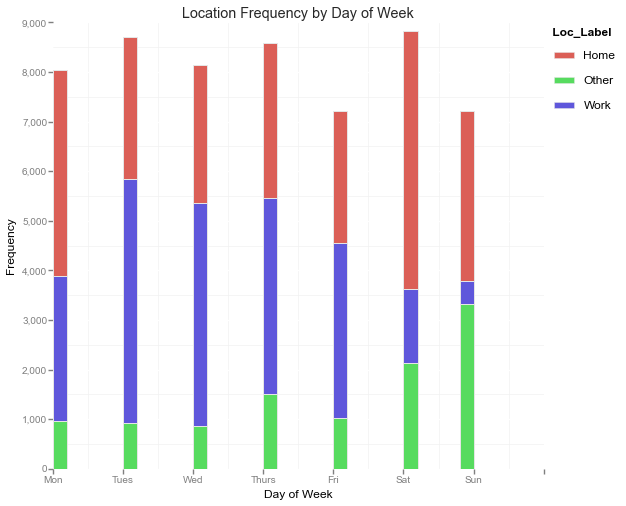

<ggplot: (285147277)>

In [35]:
weekday_label = ("Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun")

ggplot(weekday_patterns, aes("day", fill='loc_label')) + geom_bar() + \
    scale_x_continuous(name="Day of Week", labels=weekday_label) + \
    scale_y_continuous(name="Frequency", labels="comma") + \
    ggtitle("Location Frequency by Day of Week") + \
    theme_bw()

# Trend for day of week by location frequency

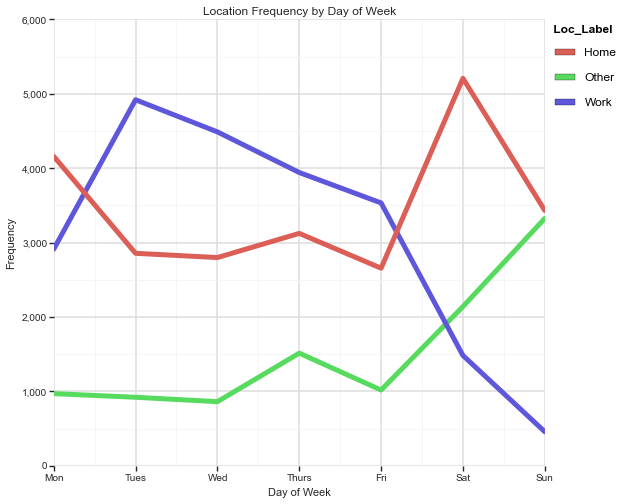

<ggplot: (291907969)>

In [36]:
wkdf = weekday_patterns[['day', 'loc_label']]
wkdf['freq'] = 0
wkdf = wkdf.groupby(['day', 'loc_label']).count().reset_index()

ggplot(wkdf, aes('day', 'freq', color='loc_label')) + geom_line(size=5) + \
    scale_x_continuous(name="Day of Week", labels=weekday_label) + \
    scale_y_continuous(name="Frequency", labels="comma") + \
    ggtitle("Location Frequency by Day of Week") + \
    theme_seaborn()

# Show location frequency by date (ggplot)

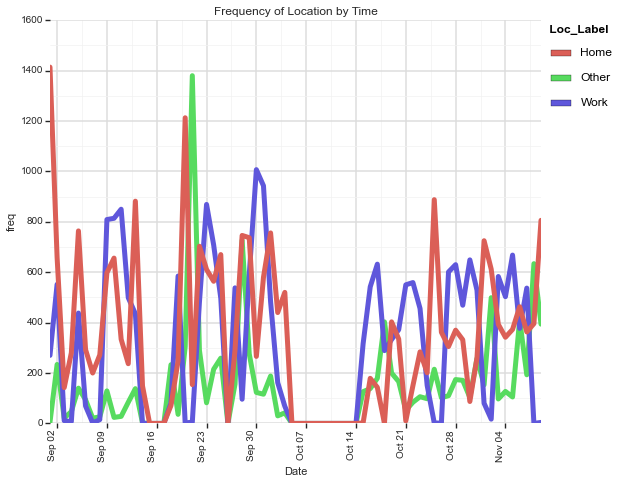

<ggplot: (325270069)>

In [37]:
date_df = weekday_patterns[['datetime', 'loc_label']]
date_df['freq'] = 0

date_df = date_df.set_index('datetime')
date_df = date_df.groupby('loc_label').resample('D', how='count').reset_index()

ggplot(date_df, aes('datetime', 'freq', color='loc_label')) + \
    geom_line(size=5) + \
    scale_x_date(name="Date", labels="%b %d", breaks=date_breaks("1 week")) + \
    ggtitle("Frequency of Location by Time") + \
    theme_seaborn() + \
    theme(axis_text_x  = element_text(angle = 90, hjust = 1))

# Day of week by time of day for each location

/Users/fnokeke/dev/student-streams/env_ss/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



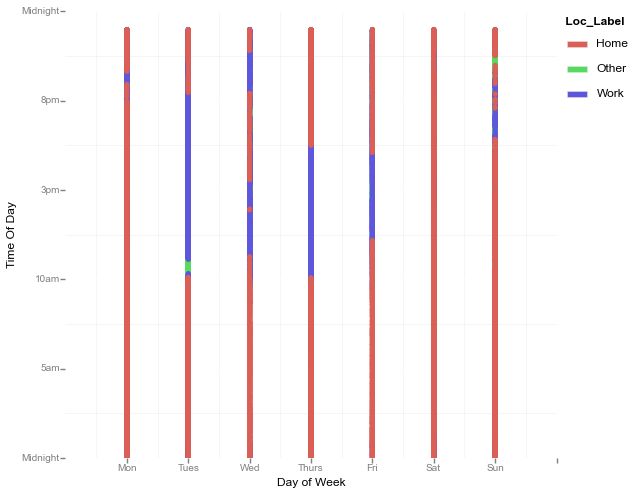

<ggplot: (317450817)>

In [38]:
day_patterns = ld_wk[['datetime', 'loc_label']]
day_patterns['day'] = day_patterns.datetime.map(lambda x: x.weekday())
day_patterns['time'] = day_patterns.datetime.map(lambda x: int(x.strftime("%H")) + float(x.strftime("%M"))/60)

weekday_label = ("Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun")
time_label = ("Midnight", "5am", "10am", "3pm", "8pm", "Midnight")

ggplot(day_patterns, aes('day', 'time', color='loc_label')) + \
    geom_point() + \
    scale_x_continuous(name = "Day of Week", breaks=range(0,8), labels=weekday_label) + \
    scale_y_continuous(name="Time of Day", limits=(0,25), labels=time_label) + \
    theme_bw()

# Different dates by time and proportion of each location

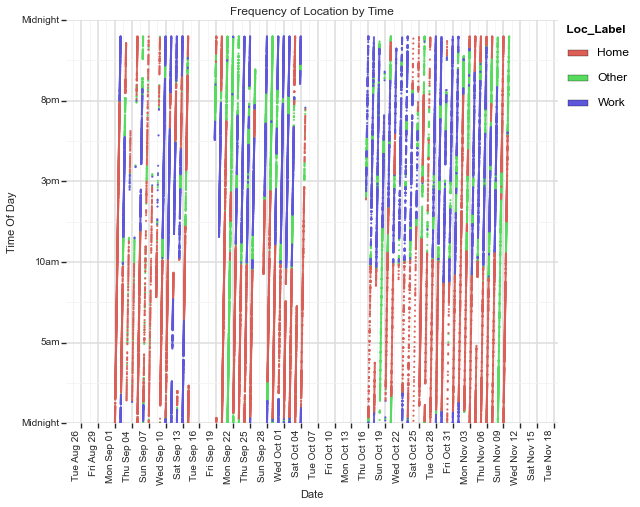

<ggplot: (319319181)>

In [39]:
time_label = ("Midnight", "5am", "10am", "3pm", "8pm", "Midnight")

date_df = weekday_patterns[['datetime', 'loc_label']]
date_df['time'] = date_df.datetime.map(lambda x: int(x.strftime("%H")) + float(x.strftime("%M"))/60)

ggplot(date_df, aes('datetime', 'time', color='loc_label')) + \
    geom_point(size=3) + \
    scale_x_date(name="Date", labels="%a %b %d", breaks=date_breaks("3 days")) + \
    scale_y_continuous(name="Time of Day", limits=(0,25), labels=time_label) + \
    ggtitle("Frequency of Location by Time") + \
    theme_seaborn() + \
    theme(axis_text_x=element_text(angle = 90, hjust = 1))

# Time left and returned from specified location

In [40]:
ld_wk.head()

,latitude,longitude,datetime,date,loc_label
167414,42.446759,-76.493432,2014-09-01 00:00:12.313,2014-09-01,home
167413,42.446759,-76.493435,2014-09-01 00:01:02.762,2014-09-01,home
167412,42.446759,-76.493437,2014-09-01 00:01:52.946,2014-09-01,home
167411,42.446763,-76.493435,2014-09-01 00:02:42.124,2014-09-01,home
167410,42.446765,-76.493434,2014-09-01 00:03:32.598,2014-09-01,home


In [41]:
def left_loc(dataframe, date, loc_label):
    if date not in dataframe.date.tolist():
        return -1
    
    all_labels = ['home', 'work', 'other']
    all_labels.remove(loc_label)
    
    df = dataframe[(dataframe.date == date)]
    locations = df.loc_label.tolist()
    
    OUT_OF_RANGE = 999999
    label_1, label_2 = all_labels[0], all_labels[1]
    index_1 = locations.index(label_1) if label_1 in locations else OUT_OF_RANGE
    index_2 = locations.index(label_2) if label_2 in locations else OUT_OF_RANGE
    first_index = min(index_1, index_2)
    
    print "index_1: %d.\nindex_2: %d." % (index_1, index_2)

    time = -99
    if first_index != OUT_OF_RANGE:
        date = df.datetime.tolist()[first_index]
        # time = int(date.strftime("%H")) + float(date.strftime("%M"))/60
        time = date
    return time

In [42]:
def returned_to_loc(dataframe, date, loc_label):
    if date not in dataframe.date.tolist():
        return -1
    
    all_labels = ['home', 'work', 'other']
    all_labels.remove(loc_label)
    
    df = dataframe[(dataframe.date == date)]
    reversed_locations = df.sort_values('datetime', ascending=False).to_list()
    locations = reversed_locations
    
    OUT_OF_RANGE = 999999
    loc_len = len(locations)
    
    label_1, label_2 = all_labels[0], all_labels[1] #TODO: remove
    
    index_1 = loc_len - 1 - locations.index(label_1) if label_1 in locations else OUT_OF_RANGE
    index_2 = loc_len - 1 - locations.index(label_2) if label_2 in locations else OUT_OF_RANGE
    first_index = min(index_1, index_2)

    time = -99
    if first_index != OUT_OF_RANGE:
        date = df.datetime.tolist()[first_index]
        time = int(date.strftime("%H")) + float(date.strftime("%M"))/60
        
        print "ret_index:", first_index

    return time

# Testing functions

In [43]:
dates = ["2014-09-01", "2014-09-02", "2014-09-03"]
dd = ld_wk[ld_wk.date=="2014-09-01"]
dd.head()

,latitude,longitude,datetime,date,loc_label
167414,42.446759,-76.493432,2014-09-01 00:00:12.313,2014-09-01,home
167413,42.446759,-76.493435,2014-09-01 00:01:02.762,2014-09-01,home
167412,42.446759,-76.493437,2014-09-01 00:01:52.946,2014-09-01,home
167411,42.446763,-76.493435,2014-09-01 00:02:42.124,2014-09-01,home
167410,42.446765,-76.493434,2014-09-01 00:03:32.598,2014-09-01,home


In [44]:
rr = [left_loc(ld_wk, d, "home") for d in dates]
rr

index_1: 1417.
index_2: 1414.
index_1: 0.
index_2: 107.
index_1: 124.
index_2: 18.


[Timestamp('2014-09-01 19:56:34.454000'),
 Timestamp('2014-09-02 00:00:33.975000'),
 Timestamp('2014-09-03 02:30:08.732000')]

# Use plotly for heatmaps of day by time

In [211]:
 tls.set_credentials_file(username='fnokeke', api_key='v44dzxrwuw')

In [215]:
selected_patterns = day_patterns[day_patterns.loc_label=='other']
df = selected_patterns[['day', 'time']]
df.time = df.time.map(lambda x: int(x))
df['freq'] = 0

dfg = df.groupby(['time', 'day']).count().unstack()
dfg.columns = dfg.columns.droplevel()
dfg = dfg.reset_index(drop=True)

dfg.columns = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
hours = range(24)
new_index = []
for h in hours: 
    if h == 0:
        new_index.append('Midnight')
    elif h < 12:
        new_index.append(str(h) + 'am')
    elif h == 12:
        new_index.append('Noon')
    else:
        value = h % 12
        new_index.append(str(value) + 'pm')    
        
dfg.index = new_index
dfg = dfg.T
dfg

,Midnight,1am,2am,3am,4am,5am,6am,7am,8am,9am,...,2pm,3pm,4pm,5pm,6pm,7pm,8pm,9pm,10pm,11pm
Mon,112,49,1,NaN,NaN,NaN,1,NaN,NaN,13,...,130,166,18,12,31,72,94,60,24,46
Tue,32,7,1,2,1,1,NaN,NaN,2,27,...,42,5,NaN,14,55,107,29,85,63,NaN
Wed,32,14,4,1,NaN,7,1,5,9,30,...,123,73,34,92,158,196,51,NaN,2,8
Thur,55,NaN,1,1,NaN,4,1,7,9,92,...,29,38,NaN,29,45,119,259,212,91,1
Fri,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,...,142,127,25,23,30,62,106,123,123,119
Sat,57,125,112,72,44,52,58,45,55,44,...,110,148,38,43,40,107,135,190,160,100
Sun,91,118,121,73,74,62,71,57,67,70,...,119,140,109,240,242,220,217,291,218,230


In [219]:
dfg.iplot(kind='heatmap',colorscale='spectral',
                        filename='cufflinks/simple-heatmap')